<a href="https://colab.research.google.com/github/linhmonkaist/-CS320-Programming-Language/blob/main/knn_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from typing import List
import math
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
# import pycountry_convert as pc
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train= pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/train.csv"); 
test= pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/test.csv"); 

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
def clean_data(df):
  drop_list= ['SellerID', 'ExpressID']
  new_df= df.drop(drop_list, axis= 1)
  new_month= pd.to_datetime(new_df['IssueDateTime']).dt.month;
  month_update= pd.Series(new_month, name='IssueDateTime');
  new_df.update(month_update);

  
  new_df['TotalGrossMassMeasure(KG)'].mask(df['AdValoremTaxBaseAmount(Won)'] < 0.001, 0, inplace=True)

  new_df['ItemPrice']= df['AdValoremTaxBaseAmount(Won)']/ df['TotalGrossMassMeasure(KG)']
  miss_index= np.where(new_df['ItemPrice'].isna())[0]
  for i in miss_index:
    ID= new_df.iloc[[i]]['ClassificationID'].get(i)
    new_df.at[i, 'ItemPrice'] = new_df[new_df['ClassificationID'] == ID]['ItemPrice'].mean()
  print(new_df.at[40588, 'ItemPrice'])
  new_df['ItemPrice'] = new_df['ItemPrice'].fillna(0)
  numeric= ['AdValoremTaxBaseAmount(Won)', 'TotalGrossMassMeasure(KG)', 'TaxRate']
  numeric= ['TotalGrossMassMeasure(KG)','ItemPrice','OriginCountry', 'TaxRate', 'AdValoremTaxBaseAmount(Won)']
  log_col = ['AdValoremTaxBaseAmount(Won)', 'TotalGrossMassMeasure(KG)']
  numeric_category= ['DeclarationOfficeID', 'TransactionNature', 'Type', 'PaymentType','BorderTransportMeans','ClassificationID']
  category= ['DisplayIndicator', 'DutyRegime', 'ProcessType', 'DeclarationOfficeID', 'TransactionNature', 'Type', 'PaymentType','BorderTransportMeans', 'ExportationCountry','OriginCountry','DeclarerID', 'ImporterID']
  # new_ID= (new_df['ClassificationID'] / 1000).apply(int);
  # new_df.update(pd.Series(new_ID, name= 'ClassificationID'));
  for col in category:
    code_col, u_col= pd.factorize(new_df[col], sort= True)
    new_df.update(pd.Series(code_col, name= col))
  # for col in log_col:
  #   val= np.log(1.0 + new_df[col])
  #   new_df[col]= val
  scaler = MinMaxScaler()
  # scaler = StandardScaler()
  # value= 5
  # scaler = RobustScaler(quantile_range=(value, 100-value))
  # for col in numeric:
  #   scaler.fit(new_df[[col]])
  #   scaled_col= scaler.transform(new_df[[col]])
  #   new_df.update(pd.DataFrame(scaled_col, columns= [col]))

  return new_df
x_raw_train= train.drop(['Fake'], axis= 1); 
y_raw_train= train['Fake']; 
x_raw= pd.concat([x_raw_train, test], ignore_index= True); 

x = clean_data(x_raw)
x = x.astype(np.float64)
x_train = x.iloc[:len(train),:];
x_test= x.iloc[len(train):,:]; 
x_copy= x.copy()
y = y_raw_train.astype(np.int64)

92.8


In [4]:
hold= x['ImporterID'].value_counts()
print(hold)
cate_imp= []
for i, row in x_train.iterrows():
  if (hold[row['ImporterID']] == 0):
    cate_imp.append(00)
  elif (hold[row['ImporterID']] < 11):
    cate_imp.append(11)
  elif (hold[row['ImporterID']] < 51):
    cate_imp.append(22)
  elif (hold[row['ImporterID']] < 251):
    cate_imp.append(33)
  else:
    cate_imp.append(44)
x_train['Class_ImportID']= cate_imp
cate_imp= []
for i, row in x_test.iterrows():
  if (hold[row['ImporterID']] == 0):
    cate_imp.append(00)
  elif (hold[row['ImporterID']] < 11):
    cate_imp.append(11)
  elif (hold[row['ImporterID']] < 51):
    cate_imp.append(22)
  elif (hold[row['ImporterID']] < 251):
    cate_imp.append(33)
  else:
    cate_imp.append(44)
x_test['Class_ImportID']= cate_imp

hold = x['ClassificationID'].value_counts()
cate_hs = []
for i, row in x_train.iterrows():
  if (row['ClassificationID'] == 0):
    cate_hs.append(0)
  elif (row['ClassificationID'] < 3):
    cate_hs.append(1)
  elif (row['ClassificationID'] < 17):
    cate_hs.append(2)
  elif (row['ClassificationID'] < 87):
    cate_hs.append(3)
  else:
    cate_hs.append(4)
x_train['Class_ClassID'] = cate_hs
cate_hs = []
for i, row in x_test.iterrows():
  if (row['ClassificationID'] == 0):
    cate_hs.append(0)
  elif (row['ClassificationID'] < 3):
    cate_hs.append(1)
  elif (row['ClassificationID'] < 17):
    cate_hs.append(2)
  elif (row['ClassificationID'] < 87):
    cate_hs.append(3)
  else:
    cate_hs.append(4)
x_test['Class_ClassID'] = cate_hs
print(x_train[train['Fake'] == 1]['Class_ClassID'].value_counts())
print(x_train[train['Fake'] == 0]['Class_ClassID'].value_counts())

3436.0     312
985.0      259
12474.0    223
931.0      189
11107.0    152
          ... 
14137.0      1
12431.0      1
13432.0      1
8568.0       1
15102.0      1
Name: ImporterID, Length: 17688, dtype: int64


<ipython-input-4-f690ecc3cac5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Class_ImportID']= cate_imp
<ipython-input-4-f690ecc3cac5>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Class_ImportID']= cate_imp
<ipython-input-4-f690ecc3cac5>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

4    8028
Name: Class_ClassID, dtype: int64
4    29719
Name: Class_ClassID, dtype: int64


<ipython-input-4-f690ecc3cac5>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Class_ClassID'] = cate_hs


In [5]:
risk_cal= ['ImporterID', 'DeclarerID', 'ClassificationID', 'OriginCountry']
for col in risk_cal: 
  hold= x_train[col].value_counts()
  fake= x_train[train['Fake'] == 1][col].value_counts()
  for id, cnt in hold.items():
    try:
      # hold[id] = fake[id] * 1.0/cnt
      if (fake[id] * 1.0/cnt > 0.9):
        hold[id] = 0.01
      else: 
        hold[id] = 0
    except:
      hold[id] = 0
  risk = []
  for i, row in x_train.iterrows():
    risk.append(hold[row[col]])
  x_train['Risk'+col]= risk
  risk = []
  for i, row in x_test.iterrows():
    try:
      risk.append(hold[row[col]])
    except:
      risk.append(0)
  x_test['Risk'+col]= risk    
print(x_train)
print(x_test)
# new_ID= (x_train['ClassificationID'] / 1000).apply(int);
# x_train.update(pd.Series(new_ID, name= 'ClassificationID'));
# new_ID= (x_test['ClassificationID'] / 1000).apply(int);
# x_test.update(pd.Series(new_ID, name= 'ClassificationID'));
# new_ID= (x_train['ImporterID'] / 100000000).apply(int);
# x_train.update(pd.Series(new_ID, name= 'ImporterID'));
# new_ID= (x_test['ImporterID'] / 100000000).apply(int);
# x_test.update(pd.Series(new_ID, name= 'ImporterID'));

<ipython-input-5-4d67afb344cb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['Risk'+col]= risk
<ipython-input-5-4d67afb344cb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Risk'+col]= risk
<ipython-input-5-4d67afb344cb>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

               ID  IssueDateTime  DeclarationOfficeID  ProcessType  \
0      30777033.0            1.0                 13.0          1.0   
1      47773104.0            1.0                 13.0          1.0   
2      80698705.0            1.0                 13.0          1.0   
3      44182350.0            1.0                  9.0          2.0   
4      14249938.0            1.0                 41.0          1.0   
...           ...            ...                  ...          ...   
37742  24481775.0           12.0                 13.0          1.0   
37743  30520377.0           12.0                  6.0          1.0   
37744  90393257.0           12.0                  9.0          1.0   
37745  23757147.0           12.0                  6.0          1.0   
37746  48147955.0           12.0                  7.0          1.0   

       TransactionNature  Type  PaymentType  BorderTransportMeans  DeclarerID  \
0                    0.0  11.0          2.0                   0.0      1091.0 

<ipython-input-5-4d67afb344cb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['Risk'+col]= risk


In [13]:
numeric= ['ItemPrice', 'TaxRate']
numeric= ['RiskImporterID',  'RiskDeclarerID',  'RiskClassificationID', 'TotalGrossMassMeasure(KG)', 'TaxRate','AdValoremTaxBaseAmount(Won)']
# numeric= ['RiskImporterID', 'RiskClassificationID', 'TotalGrossMassMeasure(KG)', 'TaxRate', 'AdValoremTaxBaseAmount(Won)'] #0.9, 2271
# numeric= ['RiskClassificationID', 'RiskImporterID', 'ItemPrice', 'TaxRate', 'AdValoremTaxBaseAmount(Won)'] #0.903 2303
# numeric= ['RiskClassificationID', 'RiskImporterID', 'TaxRate', 'AdValoremTaxBaseAmount(Won)'] #0.88 2331
numeric= ['RiskImporterID', 'TaxRate','RiskClassificationID','ItemPrice','AdValoremTaxBaseAmount(Won)', 'TotalGrossMassMeasure(KG)']
# numeric= ['AdValoremTaxBaseAmount(Won)', 'TotalGrossMassMeasure(KG)', 'TaxRate', 'ItemPrice'] #scale taxrate, 2396, 0.908 (no scal2356, 0.9100)
# numeric= ['ItemPrice', 'TotalGrossMassMeasure(KG)', 'TaxRate'] #2381, 0.910
numeric= ['TaxRate','RiskClassificationID','ItemPrice','RiskImporterID','TotalGrossMassMeasure(KG)']  #2365 0.910
# numeric= ['TotalGrossMassMeasure(KG)','AdValoremTaxBaseAmount(Won)', 'TaxRate','RiskClassificationID','ClassificationID','RiskImporterID']
numeric= ['TotalGrossMassMeasure(KG)','ItemPrice','OriginCountry', 'TaxRate', 'AdValoremTaxBaseAmount(Won)','RiskImporterID', 'RiskDeclarerID'] #2391, 0.912
# numeric= ['TotalGrossMassMeasure(KG)','ItemPrice','OriginCountry', 'TaxRate', 'AdValoremTaxBaseAmount(Won)'] #2375, 0.9166
# numeric= ['TotalGrossMassMeasure(KG)','ItemPrice','OriginCountry', 'TaxRate', 'AdValoremTaxBaseAmount(Won)'] #2391, 0.915
#,'TaxRate','RiskImporterID'
# Class_ImportID
x_knn= x_train[numeric]
x_knn_train= x_train[numeric]
x_knn_test= x_test[numeric]
new_ID= (x_knn_train['OriginCountry'] *0.1/ 100);
x_knn_train.update(pd.Series(new_ID, name= 'OriginCountry'));
new_ID= (x_knn_test['OriginCountry'] *0.1/ 100);
x_knn_test.update(pd.Series(new_ID, name= 'OriginCountry'));

# new_ID= (x_knn_train['TaxRate'] *0.1);
# x_knn_train.update(pd.Series(new_ID, name= 'TaxRate'));
# new_ID= (x_knn_test['TaxRate'] *0.1);
# x_knn_test.update(pd.Series(new_ID, name= 'TaxRate'));

new_ID= (x_knn_train['RiskImporterID'] *0.001);
x_knn_train.update(pd.Series(new_ID, name= 'RiskImporterID'));
new_ID= (x_knn_test['RiskImporterID'] *0.001);
x_knn_test.update(pd.Series(new_ID, name= 'RiskImporterID'));

# new_ID= (x_knn_train['RiskDeclarerID'] *0.001);
# x_knn_train.update(pd.Series(new_ID, name= 'RiskDeclarerID'));
# new_ID= (x_knn_test['RiskDeclarerID'] *0.001);
# x_knn_test.update(pd.Series(new_ID, name= 'RiskDeclarerID'));

# new_ID= (x_knn_train['ImporterID'] *0.1/ 10000000);
# x_knn_train.update(pd.Series(new_ID, name= 'ImporterID'));
# new_ID= (x_knn_test['ImporterID'] *0.1/ 10000000);
# x_knn_test.update(pd.Series(new_ID, name= 'ImporterID'));

# dumm= pd.get_dummies(x_train['DisplayIndicator'], drop_first= True);
# dum_train= pd.concat((dumm, x_knn_train), axis=1);
# dum_train.columns = dum_train.columns.astype(str);
# # dumm= pd.get_dummies(x_train['Class_ImportID'], drop_first= True);
# # dum_train= pd.concat((dumm, dum_train), axis=1);
# # dum_train.columns = dum_train.columns.astype(str);
# x_knn_train= dum_train 

# dumm= pd.get_dummies(x_test['DisplayIndicator'], drop_first= True);
# dum_train= pd.concat((dumm, x_knn_test), axis=1);
# dum_train.columns = dum_train.columns.astype(str);
# # dumm= pd.get_dummies(x_test['Class_ImportID'], drop_first= True);
# # dum_train= pd.concat((dumm, dum_train), axis=1);
# # dum_train.columns = dum_train.columns.astype(str);
# x_knn_test= dum_train 
# x_new_train= x_knn_train
def knn_test(df, y):
  x_train,x_test, y_train, y_test= tts(df, y, test_size= 0.15, random_state= 42)
  max_point= 0
  max_k= 0
  print(x_train.keys())
  for k in range(1, 600, 10):
    neigh= KNeighborsClassifier(n_neighbors= k, weights= 'distance');
    neigh.fit(x_train, y_train);
    predicted= neigh.predict(x_test);
    pct_correct= accuracy_score(y_test, predicted);
    print("knn "+ str(k) + ": "+ str(pct_correct))
    if (pct_correct > max_point):
      max_point= pct_correct;
      max_k= k;
  return max_point, max_k
p, k= knn_test(x_knn_train, y_raw_train)
print(p)
print(k)
#with maximum score
# x_train,x_test, y_train, y_test= tts(x_knn_train, y, test_size= 0.2, random_state= 42)
neigh= KNeighborsClassifier(n_neighbors= k, weights= 'distance');
neigh.fit(x_knn_train, y)
y_knn_pred= neigh.predict(x_knn_train)
y_test_knn_pred= neigh.predict(x_knn_test)
y_knn_col_test= y_test_knn_pred.astype(np.int64)
y_knn_col_train= y_knn_pred.astype(np.int64)
# x_train['knn_pre']= y_knn_col_train
# x_test['knn_pre'] = y_knn_col_test
# print(y_knn_col_train); 
test_ID= test[['ID']]
ans= pd.concat((test_ID, pd.Series(y_knn_col_test, name= 'Fake')), axis= 1);
# print(ans);
t = len(ans[ans['Fake'] == 1])
print(t)
print(accuracy_score(y, neigh.predict(x_knn_train)))
# ans.to_csv('submit_knn' + str(t) +'.csv', index=False)
#2356 số 1 : 0.92355
#179 is max k
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
conf_matrix = confusion_matrix(y_true=y, y_pred=y_knn_pred)

<ipython-input-13-e609ddac6dbd>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_knn_train.update(pd.Series(new_ID, name= 'OriginCountry'));
<ipython-input-13-e609ddac6dbd>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_knn_test.update(pd.Series(new_ID, name= 'OriginCountry'));
<ipython-input-13-e609ddac6dbd>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

Index(['TotalGrossMassMeasure(KG)', 'ItemPrice', 'OriginCountry', 'TaxRate',
       'AdValoremTaxBaseAmount(Won)', 'RiskImporterID', 'RiskDeclarerID'],
      dtype='object')
knn 1: 0.8811583966095708
knn 11: 0.8988168815115664
knn 21: 0.903937842133145
knn 31: 0.9087056330566837
knn 41: 0.9111778209429631
knn 51: 0.911884160339043
knn 61: 0.9117075754900229
knn 71: 0.9131202542821826
knn 81: 0.9132968391312025
knn 91: 0.9136500088292424
knn 101: 0.9134734239802225
knn 111: 0.9138265936782624
knn 121: 0.9148861027723821
knn 131: 0.915239272470422
knn 141: 0.9155924421684619
knn 151: 0.9157690270174819
knn 161: 0.9161221967155219
knn 171: 0.9157690270174819
knn 181: 0.9157690270174819
knn 191: 0.9157690270174819
knn 201: 0.9159456118665018
knn 211: 0.9159456118665018
knn 221: 0.9159456118665018
knn 231: 0.9161221967155219
knn 241: 0.9162987815645418
knn 251: 0.9162987815645418
knn 261: 0.9162987815645418
knn 271: 0.9162987815645418
knn 281: 0.9162987815645418
knn 291: 0.9164753664135618


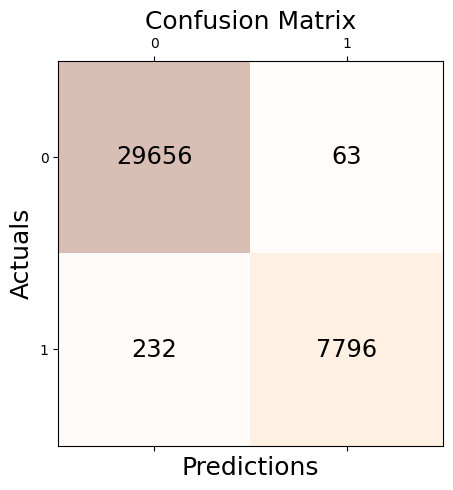

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [8]:
print(x_train.groupby(['ClassificationID'])['ItemPrice'].mean())
print(x_train.groupby(['ClassificationID'])['ItemPrice'].min())
print(x_train.groupby(['ClassificationID'])['ItemPrice'].max())
# df.groupby([Col1])[Col2].mean()

ClassificationID
1.061910e+08    10353.1
1.061990e+08    10823.8
1.062010e+08     6515.7
1.062030e+08     2957.7
1.062090e+08    11722.2
                 ...   
9.702003e+09     8353.4
9.703001e+09       55.0
9.703002e+09      255.5
9.706002e+09    99080.0
9.706009e+09    33913.1
Name: ItemPrice, Length: 3634, dtype: float64
ClassificationID
1.061910e+08    10353.1
1.061990e+08    10823.8
1.062010e+08     6515.7
1.062030e+08     2957.7
1.062090e+08    11722.2
                 ...   
9.702003e+09     8353.4
9.703001e+09       55.0
9.703002e+09      255.5
9.706002e+09    99080.0
9.706009e+09    33913.1
Name: ItemPrice, Length: 3634, dtype: float64
ClassificationID
1.061910e+08    10353.1
1.061990e+08    10823.8
1.062010e+08     6515.7
1.062030e+08     2957.7
1.062090e+08    11722.2
                 ...   
9.702003e+09     8353.4
9.703001e+09       55.0
9.703002e+09      255.5
9.706002e+09    99080.0
9.706009e+09    33913.1
Name: ItemPrice, Length: 3634, dtype: float64


In [12]:
set1 = ['ItemPrice','AdValoremTaxBaseAmount(Won)', 'TaxRate', 'TotalGrossMassMeasure(KG)'] #0.8901 in validate
set1 = ['ItemPrice','AdValoremTaxBaseAmount(Won)', 'TaxRate']
set1 = ['ItemPrice','AdValoremTaxBaseAmount(Won)', 'TaxRate', 'ClassificationID'] #0.8919 in validate, k=500
# set1 = ['AdValoremTaxBaseAmount(Won)', 'TaxRate', 'TotalGrossMassMeasure(KG)','ItemPrice'] #0.873 in validate, max_depth = 200, max_leaves = 85, have dummy
# set1 = ['Risk','ItemPrice', 'TotalGrossMassMeasure(KG)', 'TaxRate']
# set1= ['RiskImporterID',  'RiskDeclarerID',  'RiskClassificationID',  'RiskOriginCountry', 'DutyRegime']
set1= ['AdValoremTaxBaseAmount(Won)', 'TotalGrossMassMeasure(KG)','ItemPrice','OriginCountry', 'TaxRate', 'RiskDeclarerID','RiskImporterID','ExportationCountry']
x_xgb_train= x_train[set1]
x_xbg_test = x_test[set1]
# dumm= pd.get_dummies(x_train['ClassificationID'], drop_first= True);
# dum_train= pd.concat((dumm, x_xgb_train), axis=1);
# dum_tr= dum_train.drop(['Class_ImportID'], axis= 1);
# dum_train.columns = dum_train.columns.astype(str);
x_new_train= x_xgb_train
def fit_and_train(df, y):
  print("new train" + str(df.shape))
  x_train,x_test, y_train, y_test= tts(df, y, test_size= 0.2, random_state= 42)
  esti= [2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
  max_scr= 0
  k= 0
  for i in esti:
    print(i)
    model= xgb.XGBClassifier(n_estimators = i,tree_method = 'hist', grow_policy = 'lossguide', max_depth = 200, max_leaves = 85)
    # model= xgb.XGBClassifier(tree_method= 'hist',n_estimators = k, enable_categorical=True, max_cat_to_onehot=1, max_depth= 10)
    model.fit(x_train, y_train)
    y_pred= model.predict(x_test)
    scr= accuracy_score(y_test, y_pred)
    print(scr)
    if (scr >= max_scr):
      max_scr= scr
      k= i
  return k, scr
k, scr= fit_and_train(x_new_train, y_raw_train)
# model= xgb.XGBClassifier(tree_method= 'hist',n_estimators = k, enable_categorical=True, max_cat_to_onehot=1, max_depth= 10)
model= xgb.XGBClassifier(n_estimators = k,tree_method = 'hist', grow_policy = 'lossguide', max_depth = 200, max_leaves = 85)
model.fit(x_xgb_train, y_raw_train)
# x_xbg= model.predict(x_xgb_train)
# scr= accuracy_score(y_raw_train, x_xbg)
y_pred= model.predict(x_xbg_test)
test_ID= test[['ID']]
ans= pd.concat((test_ID, pd.Series(y_knn_col_test, name= 'Fake')), axis= 1);
# print(ans);
print(len(ans[ans['Fake'] == 1]))
# x_train['xgb_pred']= x_xbg.astype(np.int64)
# x_test['xgb_pred'] = y_pred.astype(np.int64)

new train(37747, 6)
2
0.7960264900662252
4
0.7990728476821192
8
0.7996026490066225
16
0.8096688741721855
32
0.823841059602649
64
0.8450331125827815
100
0.8585430463576159
200
0.8760264900662251
300
0.8850331125827815
400
0.8894039735099337
500
0.888476821192053
600
0.8871523178807947
700
0.886887417218543
800
0.8860927152317881
900
0.8870198675496689
1000
0.8860927152317881
1100
0.8850331125827815
1200


KeyboardInterrupt: ignored

In [ ]:
set1 = ['ClassificationID', 'OriginCountry','ExportationCountry','DutyRegime','TaxRate','Class_ImportID']
from sklearn.metrics import mean_squared_error as RMSE
x_xgb_train= x_train[set1]
x_xbg_test = x_test[set1]
def fit_and_train(df, y):
  print("new train" + str(df.shape))
  x_train,x_test, y_train, y_test= tts(df, y, test_size= 0.9, random_state= 42)
  esti= [2, 4, 8, 16, 32, 64, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
  max_scr= 0
  k= 0
  for i in esti:
    print(i)
    model= xgb.XGBClassifier(tree_method= 'hist',n_estimators = i, enable_categorical=True, max_cat_to_onehot=1,max_depth=10)
    model.fit(x_train, y_train)
    y_pred= model.predict(x_test)
    scr= accuracy_score(y_test, y_pred)
    print(scr)
    if (scr >= max_scr):
      max_scr= scr
      k= i
  return k, scr
k, scr= fit_and_train(x_xgb_train, y_raw_train)
model= xgb.XGBClassifier(tree_method= 'hist',n_estimators = k, enable_categorical=True, max_cat_to_onehot=1, max_depth= 10)
model.fit(x_xgb_train, y_raw_train)
x_xbg= model.predict(x_xgb_train)
scr= accuracy_score(y_raw_train, x_xbg)
y_pred= model.predict(x_xbg_test)
x_train['xgb_pred']= x_xbg.astype(np.int64)
x_test['xgb_pred'] = y_pred.astype(np.int64)

In [ ]:
x_new_train= x.drop(numeric, axis= 1);
x_new_train= pd.concat((x_new_train, pd.Series(y_knn_col_train, name= 'Fake_knn')), axis= 1);
y_new_train= y
x_new_test= x_test.drop(numeric, axis= 1); 
x_new_test= pd.concat((x_new_test, pd.Series(y_knn_col_test, name= 'Fake_knn')), axis= 1);
print(x_new_train)
print(y_new_train)
print(x_new_test)
print(x_new_test.keys())
x_new_test= x_new_test.drop(['ID'], axis= 1);
x_new_train= x_new_train.drop(['ID'], axis= 1)
# y_new_test= new_test.pop('Fake');

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
numeric= ['AdValoremTaxBaseAmount(Won)', 'TotalGrossMassMeasure(KG)','ItemPrice','OriginCountry', 'TaxRate', 'RiskImporterID','RiskDeclarerID']
kmeans = KMeans(n_clusters=2, random_state=42).fit(x_train[numeric])
print(np.sum(kmeans.predict(x_train[numeric]) == y_raw_train)/len(y_raw_train))
print(x_train['ItemPrice'].min())
print(x_train['ItemPrice'].max())